# rVAE Visualization & Unsupervised Defect Detection
This notebook mirrors `viz_vae` but loads the rotationally invariant VAE (rVAE).

What you’ll see:
- Load trained rVAE checkpoint and dataset
- Input vs reconstruction grids
- Reconstruction error histogram + anomaly threshold
- Top-K anomalous patches
- Latent embedding (t-SNE/PCA) colored by error
- Rotation angle histogram (θ)
- Spatial anomaly overlay on source images

In [14]:
# Imports and setup
import math
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Project imports
from livae.model import RVAE
from livae.utils import load_image_from_h5, clean_state_dict
from livae.data import AdaptiveLatticeDataset

# %matplotlib widget

In [15]:
# Reproducibility and device
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
# Load rVAE checkpoint and build model
ckpt_path = Path('../checkpoints/rvae_final_best5_final.pt')
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"

ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=False)
ckpt_args = ckpt.get('args', {})

latent_dim = ckpt_args.get('latent_dim', 16)
patch_size = ckpt_args.get('patch_size', 128)
print(f"Checkpoint args: latent_dim={latent_dim}, patch_size={patch_size}")

model = RVAE(latent_dim=latent_dim, in_channels=1, patch_size=patch_size).to(device)
model.load_state_dict(clean_state_dict(ckpt['model_state']))
model.eval()
model

Checkpoint args: latent_dim=16, patch_size=128


RVAE(
  (encoder): Encoder(
    (rotation_stn): RotationSTN(
      (localization): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Flatten(start_dim=1, end_dim=-1)
        (7): Linear(in_features=32768, out_features=32, bias=True)
        (8): ReLU(inplace=True)
        (9): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padd

In [17]:
# Dataset and dataloader (no augmentation for evaluation)
data_dir = Path('../data')
h5_paths = sorted([str(p) for p in data_dir.glob('*.h5')])
assert len(h5_paths) > 0, "No H5 files found in ../data"

images = [load_image_from_h5(p) for p in h5_paths]

dataset = AdaptiveLatticeDataset(
    images, patch_size=patch_size, padding=16, transform=None
)

batch_size = 256 if torch.cuda.is_available() else 64
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

len(dataset), batch_size

Adaptive lattice: 6395 unique sites - 4970 with atoms, 1425 empty sites
Adaptive lattice: 6446 unique sites - 5220 with atoms, 1226 empty sites
Adaptive lattice: 5995 unique sites - 4539 with atoms, 1456 empty sites


(18836, 64)

In [18]:
# Collect reconstructions, latents, errors, and rotations
@torch.no_grad()
def collect_stats(model, loader, dataset):
    model.eval()
    all_mu, all_logvar, all_err, all_theta = [], [], [], []
    all_idxs = []

    cum_lens = np.cumsum([0] + [len(c) for c in dataset.sample_coords])

    def map_index(global_idx):
        img_idx = np.searchsorted(cum_lens, global_idx, side='right') - 1
        local_idx = global_idx - cum_lens[img_idx]
        return int(img_idx), int(local_idx)

    start = 0
    for batch in tqdm(loader):
        x = batch.to(device)
        rotated_recon, recon, theta, mu, logvar = model(x)
        err = F.mse_loss(rotated_recon, x, reduction='none').mean(dim=(1,2,3)).cpu().numpy()
        all_mu.append(mu.cpu().numpy())
        all_logvar.append(logvar.cpu().numpy())
        all_theta.append(theta.cpu().numpy())
        all_err.append(err)
        B = x.size(0)
        idxs = [map_index(i) for i in range(start, start + B)]
        all_idxs.extend(idxs)
        start += B

    mu = np.concatenate(all_mu, axis=0)
    logvar = np.concatenate(all_logvar, axis=0)
    err = np.concatenate(all_err, axis=0)
    theta = np.concatenate(all_theta, axis=0).squeeze()
    return mu, logvar, err, theta, all_idxs

mu, logvar, rec_err, theta, idx_map = collect_stats(model, loader, dataset)
print(f"Collected: mu={mu.shape}, logvar={logvar.shape}, rec_err={rec_err.shape}, theta={theta.shape}")

100%|██████████| 295/295 [05:53<00:00,  1.20s/it]

Collected: mu=(18836, 16), logvar=(18836, 16), rec_err=(18836,), theta=(18836,)


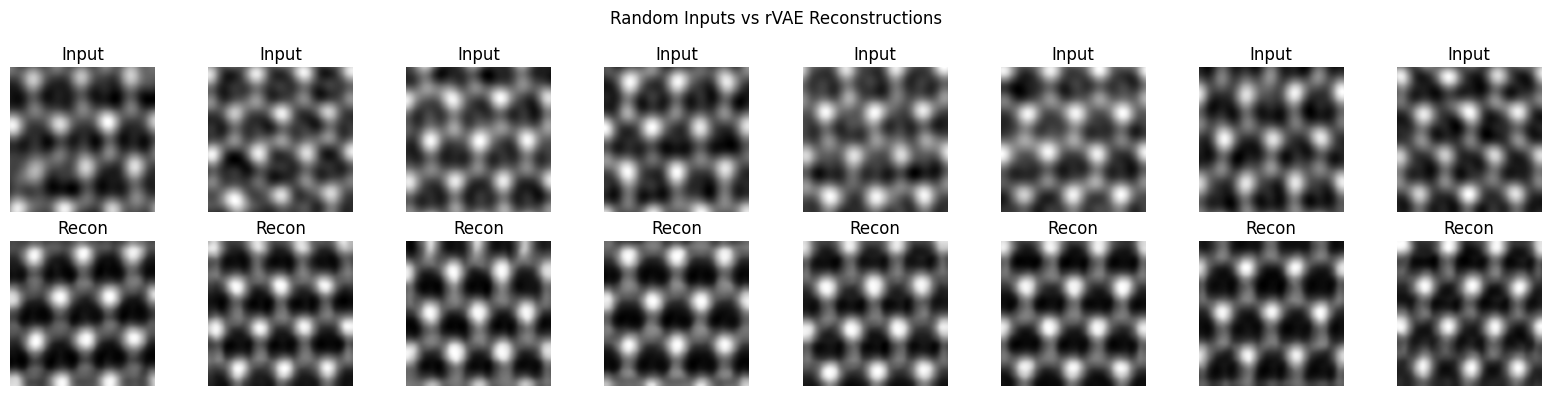

In [19]:
# Input vs reconstruction grid (rotation-corrected recon)
def show_recon_grid(dataset, model, n=8, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(dataset), size=n, replace=False)
    with torch.no_grad():
        x = torch.stack([dataset[i] for i in idxs], dim=0).to(device)
        rotated_recon, _, _, _, _ = model(x)
    x = x.cpu().numpy()
    recon = rotated_recon.cpu().numpy()

    fig = plt.figure(figsize=(2*n, 4))
    gs = GridSpec(2, n)
    for i in range(n):
        ax1 = fig.add_subplot(gs[0, i])
        ax1.imshow(x[i,0], cmap='gray')
        ax1.set_title('Input')
        ax1.axis('off')
        ax2 = fig.add_subplot(gs[1, i])
        ax2.imshow(recon[i,0], cmap='gray')
        ax2.set_title('Recon')
        ax2.axis('off')
    plt.suptitle('Random Inputs vs rVAE Reconstructions')
    plt.tight_layout()
    plt.show()

show_recon_grid(dataset, model, n=8, seed=1)

Selected anomaly threshold (98th percentile): 0.015853


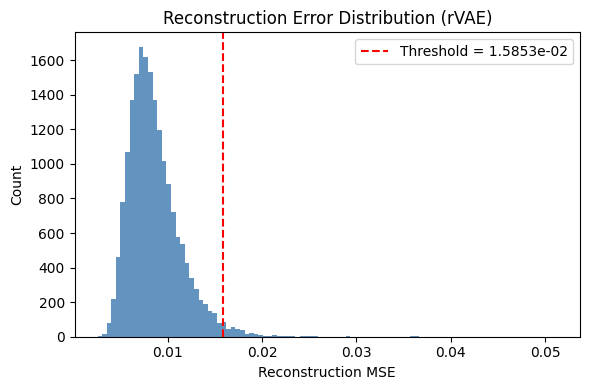

Anomalies: 377 / 18836 (2.00%)


In [20]:
# Reconstruction error histogram + threshold

def select_threshold(errors, quantile=0.98):
    return float(np.quantile(errors, quantile))

thr = select_threshold(rec_err, quantile=0.98)
print(f"Selected anomaly threshold (98th percentile): {thr:.6f}")

plt.figure(figsize=(6,4))
plt.hist(rec_err, bins=100, color='steelblue', alpha=0.85)
plt.axvline(thr, color='red', linestyle='--', label=f'Threshold = {thr:.4e}')
plt.xlabel('Reconstruction MSE')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution (rVAE)')
plt.legend()
plt.tight_layout()
plt.show()

anomaly_mask = rec_err >= thr
print(f"Anomalies: {anomaly_mask.sum()} / {len(rec_err)} ({100*anomaly_mask.mean():.2f}%)")

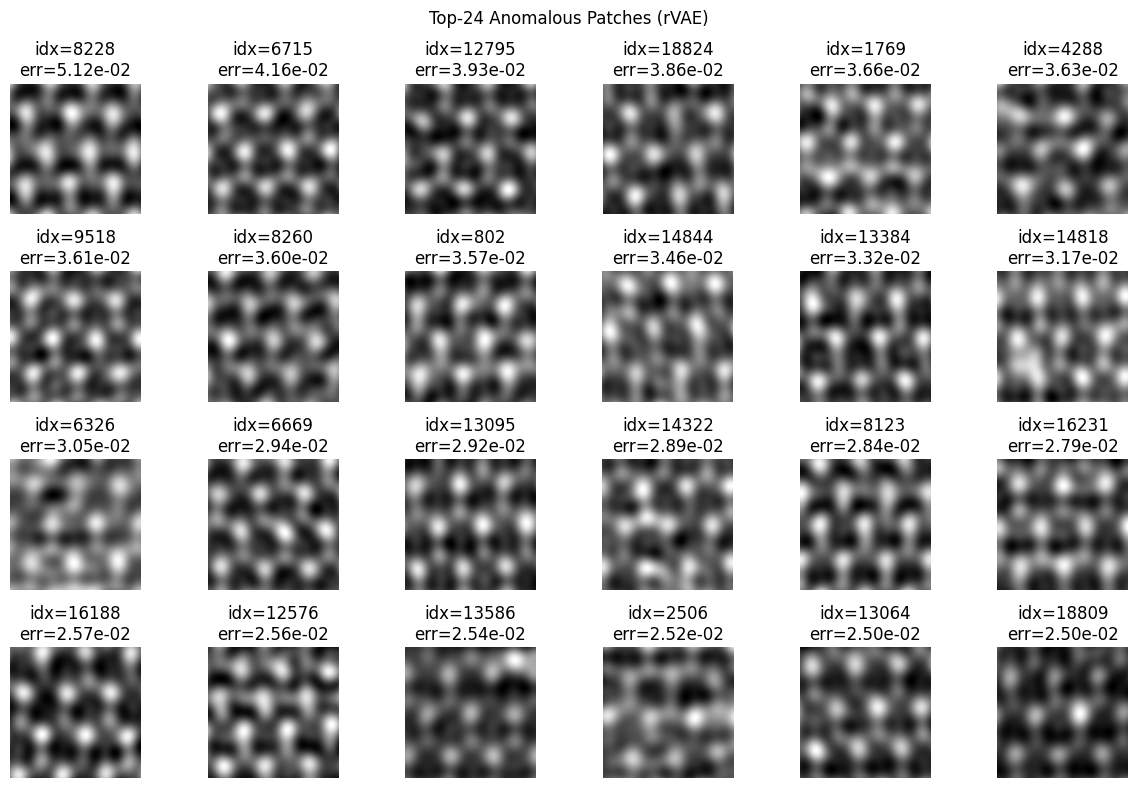

In [21]:
# Top-K anomalous patches

def show_topk_anomalies(dataset, errors, k=24):
    k = int(min(k, len(errors)))
    top_idx = np.argsort(errors)[-k:][::-1]
    ncols = 6
    nrows = math.ceil(k / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
    axes = axes.ravel()
    for i, idx in enumerate(top_idx):
        img = dataset[idx][0].numpy()
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"idx={idx}\nerr={errors[idx]:.2e}")
        ax.axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.suptitle(f'Top-{k} Anomalous Patches (rVAE)')
    plt.tight_layout()
    plt.show()

show_topk_anomalies(dataset, rec_err, k=24)

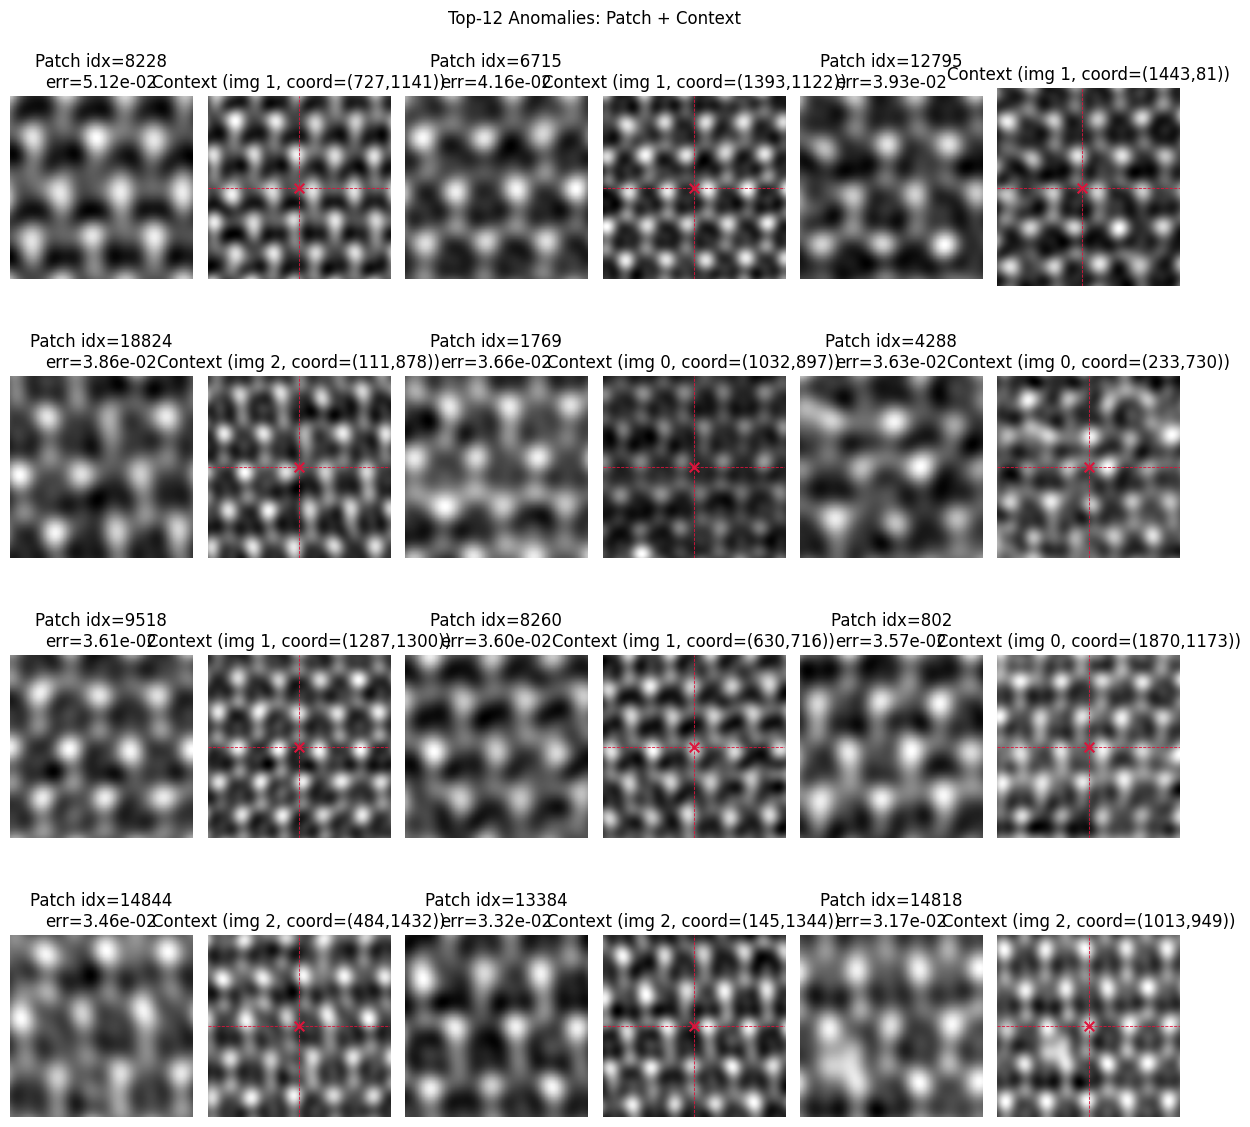

In [22]:
# Zoomed-in views of anomalous patches (patch + original context)

def show_zoomed_defects(dataset, errors, idx_map, patch_size, k=12, margin=32):

    k = int(min(k, len(errors)))

    top_idx = np.argsort(errors)[-k:][::-1]

    ncols = 3

    nrows = math.ceil(k / ncols) if k > 0 else 1

    fig = plt.figure(figsize=(4 * ncols * 1, 3 * nrows * 1))

    gs = GridSpec(nrows, 2 * ncols, figure=fig)



    for j, idx in enumerate(top_idx):

        r = j // ncols

        c = j % ncols

        ax_patch = fig.add_subplot(gs[r, 2 * c])

        ax_ctx = fig.add_subplot(gs[r, 2 * c + 1])



        img_idx, local_idx = idx_map[idx]

        patch = dataset[idx][0].numpy()

        src = dataset.images[img_idx]

        coords = dataset.sample_coords[img_idx]

        center = coords[local_idx]

        cy, cx = int(center[0]), int(center[1])



        half = patch_size // 2

        pad = half + margin

        y0 = max(cy - pad, 0)

        y1 = min(cy + pad, src.shape[0])

        x0 = max(cx - pad, 0)

        x1 = min(cx + pad, src.shape[1])

        crop = src[y0:y1, x0:x1]



        ax_patch.imshow(patch, cmap='gray')

        ax_patch.set_title(f"Patch idx={idx}\nerr={errors[idx]:.2e}")

        ax_patch.axis('off')



        ax_ctx.imshow(crop, cmap='gray')

        ax_ctx.scatter(cx - x0, cy - y0, c='crimson', marker='x', s=48, linewidths=1.5)

        ax_ctx.axhline(cy - y0, color='crimson', linestyle='--', linewidth=0.6)

        ax_ctx.axvline(cx - x0, color='crimson', linestyle='--', linewidth=0.6)

        ax_ctx.set_title(f"Context (img {img_idx}, coord=({cy},{cx}))")

        ax_ctx.axis('off')



    plt.suptitle(f"Top-{k} Anomalies: Patch + Context")

    plt.tight_layout()

    plt.show()



show_zoomed_defects(dataset, rec_err, idx_map, patch_size, k=12, margin=32)


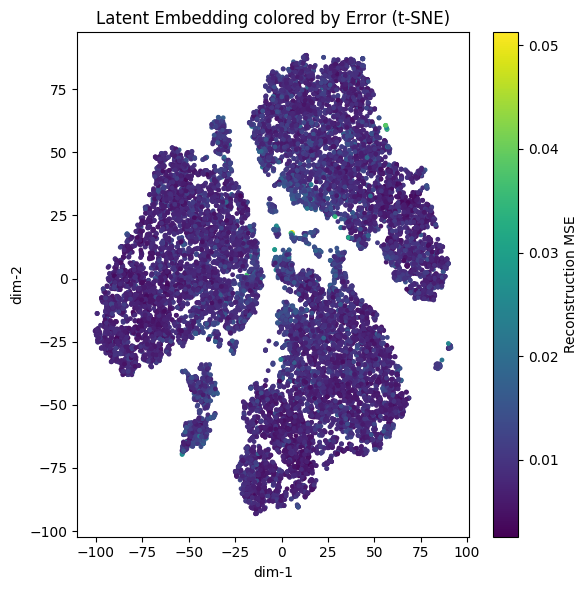

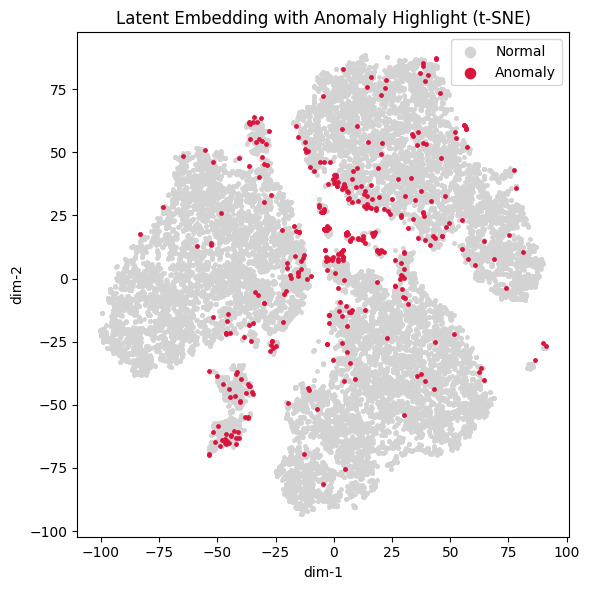

In [23]:
# Latent embedding colored by reconstruction error

def embed_latents(latent, errors, method='auto', seed=42):
    rng = np.random.RandomState(seed)
    emb = None
    used = None
    if method in ('auto', 'tsne'):
        try:
            from sklearn.manifold import TSNE
            emb = TSNE(n_components=2, random_state=rng, init='random', perplexity=30).fit_transform(latent)
            used = 't-SNE'
        except Exception:
            emb = None
    if emb is None:
        x = latent - latent.mean(axis=0, keepdims=True)
        U, S, Vt = np.linalg.svd(x, full_matrices=False)
        emb = (U[:, :2] * S[:2])
        used = 'PCA'
    return emb, used

emb, used = embed_latents(mu, rec_err, method='auto')
plt.figure(figsize=(6,6))
plt.scatter(emb[:,0], emb[:,1], c=rec_err, s=6, cmap='viridis')
plt.colorbar(label='Reconstruction MSE')
plt.title(f'Latent Embedding colored by Error ({used})')
plt.xlabel('dim-1')
plt.ylabel('dim-2')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(emb[~anomaly_mask,0], emb[~anomaly_mask,1], c='lightgray', s=6, label='Normal')
plt.scatter(emb[anomaly_mask,0], emb[anomaly_mask,1], c='crimson', s=6, label='Anomaly')
plt.legend(markerscale=3)
plt.title(f'Latent Embedding with Anomaly Highlight ({used})')
plt.xlabel('dim-1')
plt.ylabel('dim-2')
plt.tight_layout()
plt.show()

{'cluster_0': 3926, 'cluster_1': 6416, 'cluster_2': 6285, 'cluster_3': 2209}


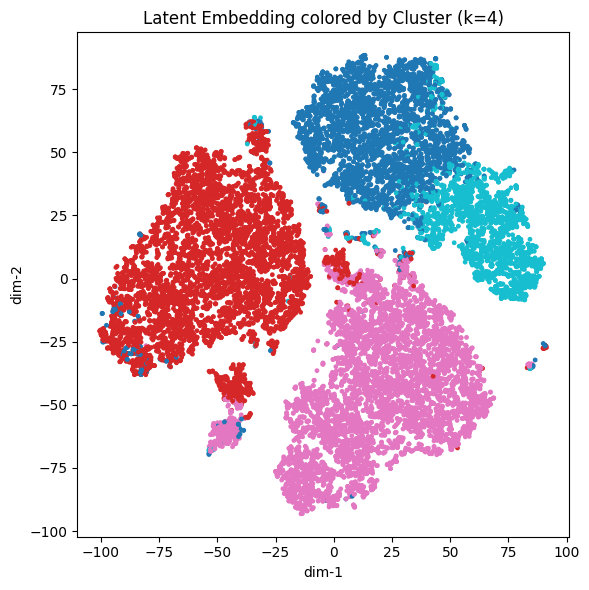

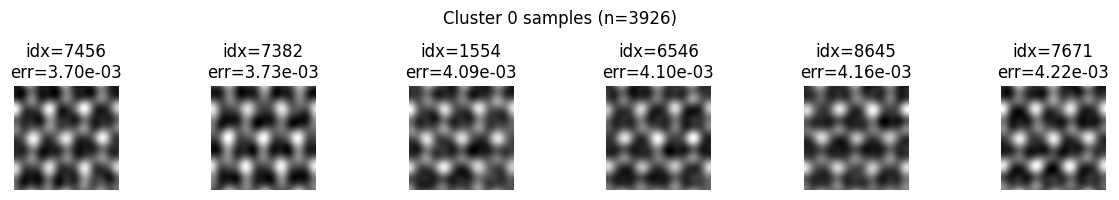

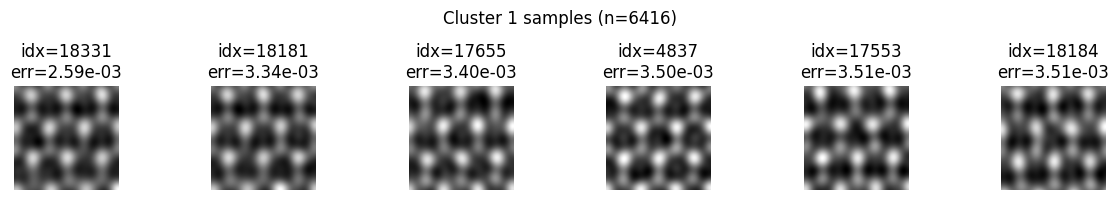

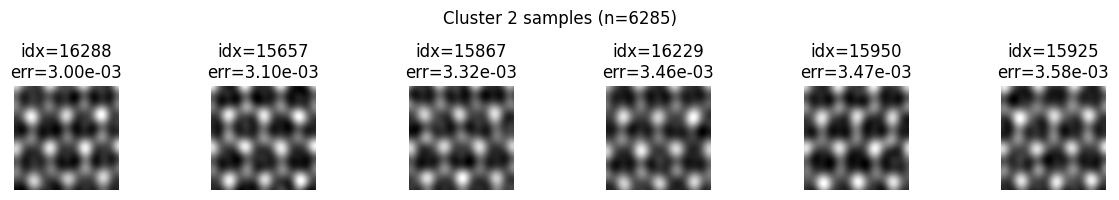

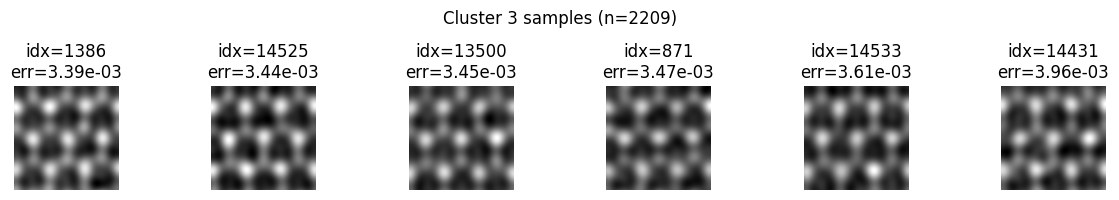

In [ ]:
%matplotlib inline
# Cluster latent space and inspect representative patches

from sklearn.cluster import KMeans



def cluster_latents(latent, n_clusters=4, seed=42, whiten=True):
    x = latent
    if whiten:
        std = latent.std(axis=0, keepdims=True) + 1e-8
        x = (latent - latent.mean(axis=0, keepdims=True)) / std
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init=10)
    labels = km.fit_predict(x)
    return labels, km.cluster_centers_



def show_cluster_samples(dataset, labels, errors, n_clusters, n_per_cluster=6):
    ncols = 6
    for c in range(n_clusters):
        idxs = np.where(labels == c)[0]
        if len(idxs) == 0:
            print(f"Cluster {c}: empty")
            continue

        ordered = idxs[np.argsort(errors[idxs])]
        take = ordered[: min(n_per_cluster, len(ordered))]
        nrows = math.ceil(len(take) / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
        axes = axes.ravel()
        for j, idx in enumerate(take):
            img = dataset[idx][0].numpy()
            axes[j].imshow(img, cmap='gray')
            axes[j].set_title(f"idx={idx}\nerr={errors[idx]:.2e}")
            axes[j].axis('off')

        for j in range(len(take), len(axes)):
            axes[j].axis('off')

        plt.suptitle(f"Cluster {c} samples (n={len(idxs)})")
        plt.tight_layout()
        plt.show()



n_clusters = 4
cluster_labels, cluster_centers = cluster_latents(mu, n_clusters=n_clusters, seed=42, whiten=True)
cluster_counts = np.bincount(cluster_labels, minlength=n_clusters)
print({f"cluster_{i}": int(c) for i, c in enumerate(cluster_counts)})



# Embedding colored by cluster assignment
plt.figure(figsize=(6,6))
plt.scatter(emb[:,0], emb[:,1], c=cluster_labels, s=6, cmap='tab10')
plt.title(f'Latent Embedding colored by Cluster (k={n_clusters})')
plt.xlabel('dim-1')
plt.ylabel('dim-2')
plt.tight_layout()
plt.show()



# Show representative samples per cluster (lowest-error examples)
show_cluster_samples(dataset, cluster_labels, rec_err, n_clusters=n_clusters, n_per_cluster=6)

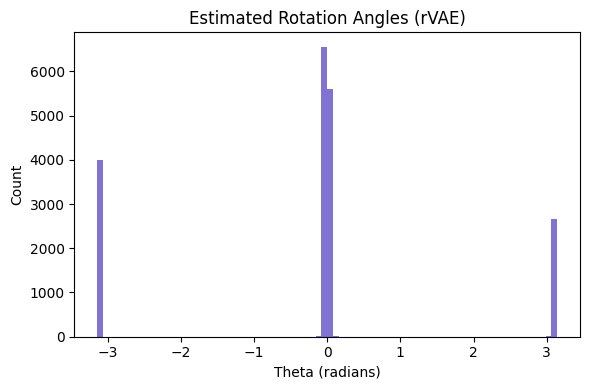

theta mean=-0.2190, std=1.8469


In [25]:
# Rotation angle distribution (theta)
plt.figure(figsize=(6,4))
plt.hist(theta, bins=80, color='slateblue', alpha=0.85)
plt.xlabel('Theta (radians)')
plt.ylabel('Count')
plt.title('Estimated Rotation Angles (rVAE)')
plt.tight_layout()
plt.show()

print(f"theta mean={theta.mean():.4f}, std={theta.std():.4f}")

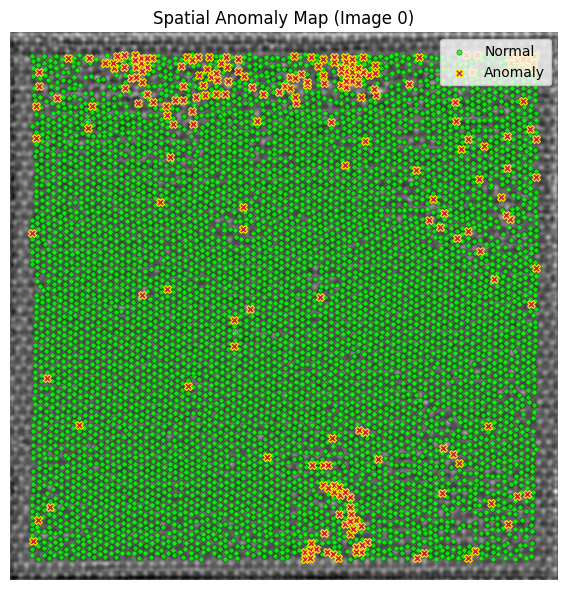

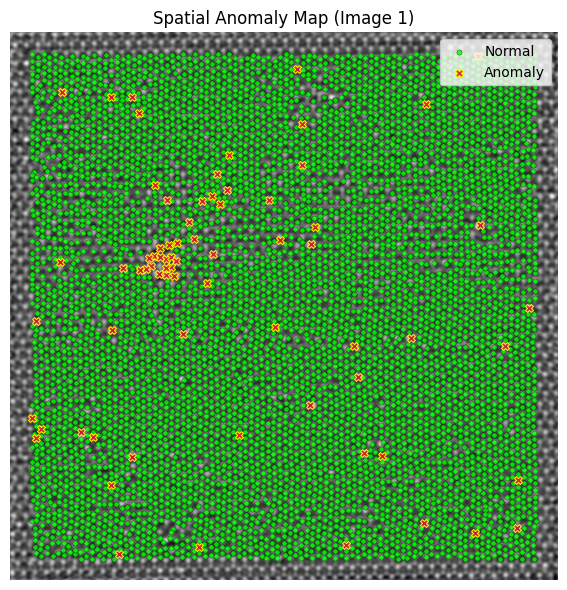

In [26]:
# Spatial anomaly map over original images

def plot_spatial_anomalies(image_idx=0):
    assert 0 <= image_idx < len(dataset.images)
    img = dataset.images[image_idx]
    coords = dataset.sample_coords[image_idx]

    indices_this_img = [i for i,(im,_) in enumerate(idx_map) if im == image_idx]
    if len(indices_this_img) == 0:
        print(f"No samples for image {image_idx}")
        return

    local_mask = np.zeros(len(coords), dtype=bool)
    for dataset_idx in indices_this_img:
        im, local = idx_map[dataset_idx]
        if local < len(coords):
            local_mask[local] = anomaly_mask[dataset_idx]

    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray')
    if len(coords) > 0:
        norm_pts = coords[~local_mask]
        if len(norm_pts) > 0:
            plt.scatter(norm_pts[:,1], norm_pts[:,0], s=14, c='lime', edgecolors='black', linewidths=0.3, alpha=0.8, label='Normal')
        ano_pts = coords[local_mask]
        if len(ano_pts) > 0:
            plt.scatter(ano_pts[:,1], ano_pts[:,0], s=32, c='crimson', marker='X', edgecolors='yellow', linewidths=0.8, alpha=0.9, label='Anomaly')
    plt.title(f'Spatial Anomaly Map (Image {image_idx})')
    plt.axis('off')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_spatial_anomalies(0)
if len(dataset.images) > 1:
    plot_spatial_anomalies(1)

## Notes
- Reconstruction error uses rotation-corrected outputs from the rVAE.
- Tune the anomaly quantile (e.g., 0.95–0.995) to adjust sensitivity.
- θ histogram helps verify the model is learning consistent orientations.
- Repeat the flow after retraining to track improvements.